<b><i><u> Python Programming <br> Group Project - Scikit Learn <br> Team 1</u></i></b>

<b><i><u>1. Data Preprocessing </u></i></b>

<b>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.1 Data Load</b>

In [1]:
#importing required libraries

import pandas as pd
import numpy as np

In [2]:
#Loading the text data file

loan_data = pd.read_csv("LoanStats_2018Q1.csv", skiprows= 1, low_memory = False) 
loan_data = loan_data[:-2]

print(loan_data.head(1))
print(loan_data.tail(1))

    id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  NaN        NaN     7200.0       7200.0           7200.0   36 months   

  int_rate  installment grade sub_grade       ...         \
0   13.58%       244.62     C        C2       ...          

  hardship_payoff_balance_amount hardship_last_payment_amount  \
0                            NaN                          NaN   

  disbursement_method  debt_settlement_flag debt_settlement_flag_date  \
0                Cash                     N                       NaN   

  settlement_status settlement_date settlement_amount  settlement_percentage  \
0               NaN             NaN               NaN                    NaN   

   settlement_term  
0              NaN  

[1 rows x 145 columns]
         id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
107863  NaN        NaN    14000.0      14000.0          13975.0   36 months   

       int_rate  installment grade sub_grade       ...         \
1

<b>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.2 Fill Missing Values and Select Required Columns
</b>

In [3]:
# Fill missing values for the requires columns

loan_data['dti'] = loan_data['dti'].fillna(0)
loan_data['avg_cur_bal'] = loan_data['avg_cur_bal'].fillna(0)

In [4]:
#Selecting required columns for each regression

loan_data_lin = loan_data.filter(items = ["application_type", 'home_ownership',"funded_amnt","annual_inc", "delinq_2yrs", 
                                          "loan_amnt", "max_bal_bc", "mort_acc", "num_accts_ever_120_pd", "num_actv_bc_tl", 
                                          "num_actv_rev_tl", "num_bc_sats"])

loan_data_log = loan_data.filter(items = ['home_ownership',"acc_now_delinq" , "annual_inc", "avg_cur_bal", "delinq_amnt", 
                                          "dti" , "mort_acc", "pub_rec_bankruptcies", "grade"])

<b>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.3 Function to create dummy variables</b>

In [5]:
# Creating dummy variables for categorical predictors

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

def getdummies(res, ls):
    def encode(encode_df):
        encode_df = np.array(encode_df)
        enc = OneHotEncoder()
        le = LabelEncoder()
        le.fit(encode_df)
        res1 = le.transform(encode_df).reshape(-1, 1)
        enc.fit(res1)
        return pd.DataFrame(enc.transform(res1).toarray()), le, enc

    decoder = []
    outres = pd.DataFrame({'A' : []})

    for l in ls:
        cat, le, enc = encode(res[l])
        cat.columns = [l+str(x) for x in cat.columns]
        outres.reset_index(drop=True, inplace=True)
        outres = pd.concat([outres, cat], axis = 1)
        decoder.append([le,enc])     
    
    return (outres, decoder)

<b><i><u>2. Linear Regression</u></i></b>

<b>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1 Call Dummy Variable Function and Split Predictors and Target</b>

In [6]:
#Identifying categorical predictors to create dummy variables
categorical_lin = [ "application_type", 'home_ownership']

#Calling the dummy variable creation function
res = getdummies(loan_data_lin[categorical_lin],categorical_lin)
df = res[0]
decoder = res[1]

#Separating the predictors and target variable
lin_X = pd.concat([df,loan_data_lin],axis=1)
lin_X = lin_X.drop(columns = ['A',"application_type", 'home_ownership','funded_amnt'])

lin_y=loan_data_lin['funded_amnt']

<b>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2 Test & Train Split</b>

In [7]:
#Split the data into test and training datasets
from sklearn.model_selection import train_test_split

lin_X_train, lin_X_test, lin_y_train, lin_y_test = train_test_split(lin_X, lin_y, test_size=0.25, random_state=42)

<b>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.3 Make Model</b>

In [8]:
#Train linear regression model
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(lin_X_train, lin_y_train)

print('Coefficients: \n', regr.coef_)

Coefficients: 
 [-2.47649724e-12  2.47647741e-12  1.07655184e-10 -4.89695471e-11
 -2.95876278e-11 -2.90979362e-11  5.40539168e-17 -7.10427651e-13
  1.00000000e+00  7.50553917e-17  2.76764126e-13 -7.16360960e-14
 -1.72281392e-12  1.23101893e-12  7.43488123e-13]


In [9]:
#Predict values of test set based on trained model
lin_y_pred = regr.predict(lin_X_test)

<b>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.4 Model Summary</b>

In [10]:
#Assessing model accuracy. Getting summary statistics
from sklearn.metrics import mean_squared_error, r2_score

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(lin_y_test, lin_y_pred))

# Explained variance score: 1 is perfect prediction
print('R-Squared value is: %.2f' % r2_score(lin_y_test, lin_y_pred))

Mean squared error: 0.00
R-Squared value is: 1.00


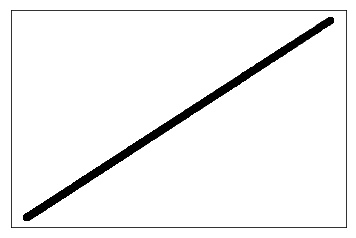

In [12]:
#Plot predictions with test variables 
import matplotlib.pyplot as plt

plt.scatter(lin_y_pred, lin_y_test,  color='black')

plt.xticks(())
plt.yticks(())

plt.show()

<b><i><u>3. Logistic Regression</u></i></b>

<b>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1 Balance Target Variable</b>

In [13]:
#Converting the target categorical variable to numeric

def conv_grade(x):
    if(x == 'A'):
        r = 'A'
    elif(x == 'B'):
        r = 'B'
    elif(x == 'C'):
        r = 'C'
    elif(x == 'D'):
        r = 'D'
    else:
        r = 'D'
    return r

print("Before : ")
print(loan_data_log.grade.value_counts())
loan_data_log['grade'] = loan_data_log['grade'].apply(conv_grade)
print("After : ")
print(loan_data_log.grade.value_counts())

Before : 
B    32482
C    28747
A    26769
D    15377
E     3691
F      682
G      116
Name: grade, dtype: int64
After : 
B    32482
C    28747
A    26769
D    19866
Name: grade, dtype: int64


<b>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2 Call Dummy Variable Function and Split Predictors and Target</b>

In [14]:
#Identifying categorical predictors to create dummy variables
categorical_log = [ 'home_ownership']

#Calling the dummy variable creation function
res = getdummies(loan_data_log[categorical_log],categorical_log)
df = res[0]
decoder = res[1]

#Separating the predictors and target variable
log_X = pd.concat([df,loan_data_log],axis=1)
log_X = log_X.drop(columns = ['A', 'home_ownership','grade'])

log_y=loan_data_log['grade']

<b>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3 Test & Train Split</b>

In [15]:
#Split the data into test and training datasets

from sklearn.model_selection import train_test_split

log_X_train, log_X_test, log_y_train, log_y_test = train_test_split(log_X, log_y, test_size=0.25, random_state = 55)

<b>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.4 Make Model</b>

In [16]:
from sklearn.linear_model import LogisticRegression

#create logisitic regression object and fitting the data with the classifier
logitR = LogisticRegression(dual=False, tol=0.0001, solver="lbfgs", multi_class='ovr',random_state=55)
logitR.fit(log_X_train, log_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=55, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
#predicting the values of the test dataset
log_pred_y = logitR.predict(log_X_test)
log_pred_p = logitR.predict_proba(log_X_test)

<b>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.5 Model Summary</b>

Confusion Matrix :
[[1746 3998  938   67]
 [1595 4853 1639  144]
 [1004 4005 1948  165]
 [ 515 2660 1523  166]]


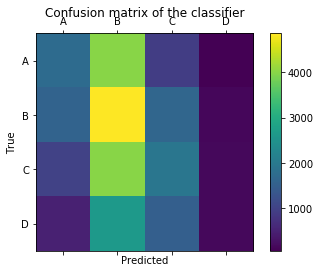


Overall Precision Score of Model :  0.32509904497039666

Classification Report :
             precision    recall  f1-score   support

          A       0.36      0.26      0.30      6749
          B       0.31      0.59      0.41      8231
          C       0.32      0.27      0.30      7122
          D       0.31      0.03      0.06      4864

avg / total       0.33      0.32      0.29     26966



In [18]:
#Assessing model accuracy. Getting summary statistics
from sklearn.metrics import confusion_matrix, precision_score, classification_report

#Loading the confusion matrix module 
labels = ["A","B","C","D"]
conf_mat= confusion_matrix(log_y_test, log_pred_y,labels = ["A","B","C","D"])
print("Confusion Matrix :")
print(conf_mat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#Calculating the precision score
print("\nOverall Precision Score of Model : ",precision_score(log_y_test, log_pred_y, average = 'macro'))

#Genrating classification report
print("\nClassification Report :")
print(classification_report(log_y_test,log_pred_y))